
Source codes for Python Machine Learning By Example 4th Edition (Packt Publishing)

Chapter 5 Predicting Stock Price with Regression Algorithms

Author: Yuxi (Hayden) Liu (yuxi.liu.ece@gmail.com)


# Estimating with decision tree regression 

## Transitioning from classification trees to regression trees

In [1]:
import numpy as np

In [2]:
# Mean squared error calculation function given continuous targets of a data set,
def mse(targets):
    # When the set is empty
    if targets.size == 0:
        return 0
    return np.var(targets)

In [3]:
def weighted_mse(groups):
    total = sum(len(group) for group in groups)
    weighted_sum = 0.0
    for group in groups:
        weighted_sum += len(group) / float(total) * mse(group)
    return weighted_sum

In [4]:
print(f'{mse(np.array([1, 2, 3])):.4f}')
print(f'{weighted_mse([np.array([1, 2, 3]), np.array([1, 2])]):.4f}')

0.6667
0.5000


In [5]:
print(f'type-semi: {weighted_mse([np.array([600, 400, 700]), np.array([700, 800])]):.4f}')
print(f'bedroom-2: {weighted_mse([np.array([700, 400]), np.array([600, 800, 700])]):.4f}')
print(f'bedroom-3: {weighted_mse([np.array([600, 800]), np.array([700, 400, 700])]):.4f}')
print(f'bedroom-4: {weighted_mse([np.array([700]), np.array([600, 700, 800, 400])]):.4f}')


print(f'bedroom-2: {weighted_mse([np.array([]), np.array([600, 400, 700])]):.4f}')
print(f'bedroom-3: {weighted_mse([np.array([400]), np.array([600, 700])]):.4f}')
print(f'bedroom-4: {weighted_mse([np.array([400, 600]), np.array([700])]):.4f}')

type-semi: 10333.3333
bedroom-2: 13000.0000
bedroom-3: 16000.0000
bedroom-4: 17500.0000
bedroom-2: 15555.5556
bedroom-3: 1666.6667
bedroom-4: 6666.6667


## Implementing decision tree regression 

In [6]:
def split_node(X, y, index, value):
    x_index = X[:, index]
    # if this feature is numerical
    if type(X[0, index]) in [int, float]:
        mask = x_index >= value
    # if this feature is categorical
    else:
        mask = x_index == value
    # split into left and right child
    left = [X[~mask, :], y[~mask]]
    right = [X[mask, :], y[mask]]
    return left, right


In [7]:
def get_best_split(X, y):
    best_index, best_value, best_score, children = None, None, 1e10, None
    for index in range(len(X[0])):
        for value in np.sort(np.unique(X[:, index])):
            groups = split_node(X, y, index, value)
            impurity = weighted_mse([groups[0][1], groups[1][1]])
            if impurity < best_score:
                best_index, best_value, best_score, children = index, value, impurity, groups
    return {'index': best_index, 'value': best_value, 'children': children}


In [8]:
def get_leaf(targets):
    # Obtain the leaf as the mean of the targets
    return np.mean(targets)


In [9]:
def split(node, max_depth, min_size, depth):
    left, right = node['children']
    del (node['children'])
    if left[1].size == 0:
        node['right'] = get_leaf(right[1])
        return
    if right[1].size == 0:
        node['left'] = get_leaf(left[1])
        return
    # Check if the current depth exceeds the maximal depth
    if depth >= max_depth:
        node['left'], node['right'] = get_leaf(left[1]), get_leaf(right[1])
        return
    # Check if the left child has enough samples
    if left[1].size <= min_size:
        node['left'] = get_leaf(left[1])
    else:
        # It has enough samples, we further split it
        result = get_best_split(left[0], left[1])
        result_left, result_right = result['children']
        if result_left[1].size == 0:
            node['left'] = get_leaf(result_right[1])
        elif result_right[1].size == 0:
            node['left'] = get_leaf(result_left[1])
        else:
            node['left'] = result
            split(node['left'], max_depth, min_size, depth + 1)
    # Check if the right child has enough samples
    if right[1].size <= min_size:
        node['right'] = get_leaf(right[1])
    else:
        # It has enough samples, we further split it
        result = get_best_split(right[0], right[1])
        result_left, result_right = result['children']
        if result_left[1].size == 0:
            node['right'] = get_leaf(result_right[1])
        elif result_right[1].size == 0:
            node['right'] = get_leaf(result_left[1])
        else:
            node['right'] = result
            split(node['right'], max_depth, min_size, depth + 1)
            

In [10]:
def train_tree(X_train, y_train, max_depth, min_size):
    root = get_best_split(X_train, y_train)
    split(root, max_depth, min_size, 1)
    return root


In [11]:
X_train = np.array([['semi', 3],
                    ['detached', 2],
                    ['detached', 3],
                    ['semi', 2],
                    ['semi', 4]], dtype=object)

y_train = np.array([600, 700, 800, 400, 700])

tree = train_tree(X_train, y_train, 2, 2)

In [12]:
CONDITION = {'numerical': {'yes': '>=', 'no': '<'},
             'categorical': {'yes': 'is', 'no': 'is not'}}
def visualize_tree(node, depth=0):
    if isinstance(node, dict):
        if type(node['value']) in [int, float]:
            condition = CONDITION['numerical']
        else:
            condition = CONDITION['categorical']
        print('{}|- X{} {} {}'.format(depth * '  ', node['index'] + 1, condition['no'], node['value']))
        if 'left' in node:
            visualize_tree(node['left'], depth + 1)
        print('{}|- X{} {} {}'.format(depth * '  ', node['index'] + 1, condition['yes'], node['value']))
        if 'right' in node:
            visualize_tree(node['right'], depth + 1)
    else:
        print('{}[{}]'.format(depth * '  ', node))

visualize_tree(tree)

|- X1 is not detached
  |- X2 < 3
    [400.0]
  |- X2 >= 3
    [650.0]
|- X1 is detached
  [750.0]


In [13]:
# Directly use DecisionTreeRegressor from scikit-learn
from sklearn import datasets
housing = datasets.fetch_california_housing()

In [14]:
num_test = 10    # the last 10 samples as testing set
X_train = housing.data[:-num_test, :]
y_train = housing.target[:-num_test]
X_test = housing.data[-num_test:, :]
y_test = housing.target[-num_test:]

from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=10, 
                                  min_samples_split=3, 
                                  random_state=42)

regressor.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=10, min_samples_split=3, random_state=42)

In [15]:
predictions = regressor.predict(X_test)
print(predictions)
print(y_test)

[1.29568298 1.29568298 1.29568298 1.11946842 1.29568298 0.66193704
 0.82554167 0.8546936  0.8546936  0.8546936 ]
[1.12  1.072 1.156 0.983 1.168 0.781 0.771 0.923 0.847 0.894]


## Implementing a regression forest

In [16]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, 
                                  max_depth=10, 
                                  min_samples_split=3,
                                  random_state=42)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)
print(predictions)


[1.30139229 1.2888858  1.23525246 1.08462371 1.23994121 0.7851888
 0.90767436 0.8324851  0.857512   0.90001118]


# Evaluating regression performance

In [17]:
from sklearn import datasets
diabetes = datasets.load_diabetes()
num_test = 30    # the last 30 samples as testing set
X_train = diabetes.data[:-num_test, :]
y_train = diabetes.target[:-num_test]
X_test = diabetes.data[-num_test:, :]
y_test = diabetes.target[-num_test:]
param_grid = {
    "alpha": [1e-07, 1e-06, 1e-05],
    "penalty": [None, "l2"],
    "eta0": [0.03, 0.05, 0.1],
    "max_iter": [500, 1000]
}

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
regressor = SGDRegressor(loss='squared_error',
                         learning_rate='constant',
                         random_state=42)
grid_search = GridSearchCV(regressor, param_grid, cv=3)

In [18]:
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

regressor_best = grid_search.best_estimator_

{'alpha': 1e-07, 'eta0': 0.05, 'max_iter': 500, 'penalty': None}


In [19]:
predictions = regressor_best.predict(X_test)

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(mean_squared_error(y_test, predictions))

print(mean_absolute_error(y_test, predictions))

print(r2_score(y_test, predictions))


1933.375567511739
35.483021678336264
0.6247482987860085


## Predicting stock prices with the three regression algorithms

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [22]:
# Reusing the feature generation function we developed
def generate_features(df):
    """
    Generate features for a stock/index based on historical price and performance
    @param df: dataframe with columns "Open", "Close", "High", "Low", "Volume", "Adj Close"
    @return: dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    # 6 original features
    df_new['open'] = df['Open']
    df_new['open_1'] = df['Open'].shift(1)
    df_new['close_1'] = df['Close'].shift(1)
    df_new['high_1'] = df['High'].shift(1)
    df_new['low_1'] = df['Low'].shift(1)
    df_new['volume_1'] = df['Volume'].shift(1)
    # 31 generated features
    # average price
    df_new['avg_price_5'] = df['Close'].rolling(5).mean().shift(1)
    df_new['avg_price_30'] = df['Close'].rolling(21).mean().shift(1)
    df_new['avg_price_365'] = df['Close'].rolling(252).mean().shift(1)
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    # average volume
    df_new['avg_volume_5'] = df['Volume'].rolling(5).mean().shift(1)
    df_new['avg_volume_30'] = df['Volume'].rolling(21).mean().shift(1)
    df_new['avg_volume_365'] = df['Volume'].rolling(252).mean().shift(1)
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    # standard deviation of prices
    df_new['std_price_5'] = df['Close'].rolling(5).std().shift(1)
    df_new['std_price_30'] = df['Close'].rolling(21).std().shift(1)
    df_new['std_price_365'] = df['Close'].rolling(252).std().shift(1)
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']
    # standard deviation of volumes
    df_new['std_volume_5'] = df['Volume'].rolling(5).std().shift(1)
    df_new['std_volume_30'] = df['Volume'].rolling(21).std().shift(1)
    df_new['std_volume_365'] = df['Volume'].rolling(252).std().shift(1)
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    # # return
    df_new['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
    df_new['return_365'] = ((df['Close'] - df['Close'].shift(252)) / df['Close'].shift(252)).shift(1)
    df_new['moving_avg_5'] = df_new['return_1'].rolling(5).mean().shift(1)
    df_new['moving_avg_30'] = df_new['return_1'].rolling(21).mean().shift(1)
    df_new['moving_avg_365'] = df_new['return_1'].rolling(252).mean().shift(1)
    # the target
    df_new['close'] = df['Close']
    df_new = df_new.dropna(axis=0)
    return df_new

In [23]:
data_raw = pd.read_csv('19900101_20230630.csv', index_col='Date')
data = generate_features(data_raw)

start_train = '1990-01-01'
end_train = '2022-12-31'

start_test = '2023-01-01'
end_test = '2023-06-30'

data_train = data.loc[start_train:end_train]
X_train = data_train.drop('close', axis=1).values
y_train = data_train['close'].values

print(X_train.shape)
print(y_train.shape)

(8061, 37)
(8061,)


In [24]:
data_test = data.loc[start_test:end_test]
X_test = data_test.drop('close', axis=1).values
y_test = data_test['close'].values

print(X_test.shape)

(124, 37)


In [25]:
# First experiment with linear regression

scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [26]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

In [27]:
param_grid = {
    "alpha": [1e-4, 3e-4, 1e-3],
    "eta0": [0.01, 0.03, 0.1],
}


lr = SGDRegressor(penalty='l2', max_iter=5000, random_state=42)
grid_search = GridSearchCV(lr, param_grid, cv=tscv, scoring='r2')
grid_search.fit(X_scaled_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=SGDRegressor(max_iter=5000, random_state=42),
             param_grid={'alpha': [0.0001, 0.0003, 0.001],
                         'eta0': [0.01, 0.03, 0.1]},
             scoring='r2')

In [28]:
print(grid_search.best_params_)

lr_best = grid_search.best_estimator_

predictions_lr = lr_best.predict(X_scaled_test)


{'alpha': 0.0001, 'eta0': 0.1}


In [29]:
print(f'R^2: {r2_score(y_test, predictions_lr):.3f}')


R^2: 0.959


In [30]:
param_grid = {
    'max_depth': [20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

dt = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=tscv, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 50],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2')

In [31]:
print(grid_search.best_params_)
dt_best = grid_search.best_estimator_

predictions_dt = dt_best.predict(X_test)

print(f'R^2: {r2_score(y_test, predictions_dt):.3f}')


{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
R^2: 0.912


In [32]:
# Experiment with random forest
param_grid = {
    'max_depth': [20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

rf = RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=tscv, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(n_estimators=30, n_jobs=-1,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [20, 30, 50],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2')

In [33]:
print(grid_search.best_params_)
rf_best = grid_search.best_estimator_

predictions_rf = rf_best.predict(X_test)


{'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [34]:
print(f'R^2: {r2_score(y_test, predictions_rf):.3f}')

R^2: 0.937


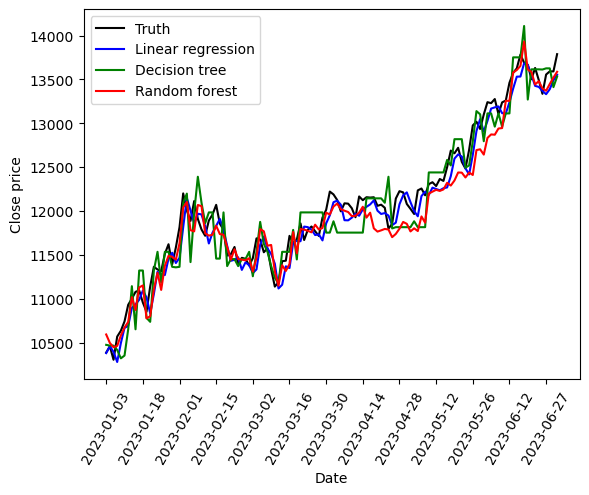

In [35]:
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.plot(data_test.index, y_test, c='k')
plt.plot(data_test.index, predictions_lr, c='b')
plt.plot(data_test.index, predictions_dt, c='g')
plt.plot(data_test.index, predictions_rf, c='r')
plt.xticks(range(0, 130, 10), rotation=60)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Close price', fontsize=10)
plt.legend(['Truth', 'Linear regression', 'Decision tree', 'Random forest'], fontsize=10)
plt.show()

---

Readers may ignore the next cell.

In [36]:
!jupyter nbconvert --to python ch5_part2.ipynb --TemplateExporter.exclude_input_prompt=True

[NbConvertApp] Converting notebook ch5_part2.ipynb to python
[NbConvertApp] Writing 13958 bytes to ch5_part2.py
